<a href="https://colab.research.google.com/github/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, set up the required Python modules and perform some general configuration.

(This part of the code follows the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb) that you should already be familiar with.)

Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets

Both of these packages are used extensively on this course.

In [1]:
!pip3 install -q transformers datasets

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [2]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [3]:
import logging

logging.disable(logging.INFO)

---

# Download and prepare data

We will again use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

In [4]:
import datasets


dataset = datasets.load_dataset("imdb")
del dataset["unsupervised"]
dataset=dataset.shuffle()
dataset["test"]=dataset["test"].select(range(400)) # downsample test data

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Let's see what the dataset contains:

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})


and print out an example:

In [6]:
pprint(dataset["train"][0])

{'label': 0,
 'text': 'When I rented "Unhinged", I was expecting a gore movie. The box even '
         'claimed that the movie had extreme scenes of violence that were cut '
         'from the theatrical release (I now have serious doubts about this '
         'being released in the theater). After finishing the movie, I '
         'wondered how it could even receive a video release.<br /><br />The '
         'plot is as follows: A group of three young women on a car trip crash '
         'their car into a tree. These women somehow manage to make their way '
         'to a mansion, which contains an extremely sexist woman. Beyond this '
         'point, the movie is mainly composed of useless scenes that are '
         'intended to make the movie long enough for release.<br /><br />One '
         'of the things that makes this movie awful is the acting. Lisa '
         'Munson, who plays the main character, looks as though she is reading '
         'her lines off cue cards. The others 

---

# Tokenize and vectorize data

(This part of the code follows the [MLP](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb) and [CNN notebooks](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb) that you should already be familiar with.)

To tokenize and vectorize the texts of our dataset, we will again use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models). Here, our texts are in English, and we'll load the tokenizer for the [`bert-base-cased`](https://huggingface.co/bert-base-cased) model.

(**Note**: we're not actually using the BERT model here, just its tokenizer.) 

In [7]:
import transformers

model_name = "bert-base-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

As in the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb), we will define a simple tokenization function and tokenize and vectorize our whole dataset with the tokenizer by calling the [`Dataset.map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) function.

Note that here we're providing a `max_length` argument and `truncation=True` in the tokenizer call. This limits the maximum length of outputs to the given length (see the [tokenizers documentation](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) for details).

In [8]:
# Define a simple function that applies the tokenizer

# maximum length of BERT models is 512 (position embeddings)

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True,
    )

# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize)

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

---

# Build model

* Ready-made model from [HF transformers](https://huggingface.co/transformers/)
* BertForSequenceClassification
  * Pre-trained BERT encoder
  * CLS embedding + linear + tanh
* [Source code](https://github.com/huggingface/transformers/blob/v4.17.0/src/transformers/models/bert/modeling_bert.py#L1501)

In [9]:
import torch
import transformers

model_name = "bert-base-cased"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

---

# Configure and train model

The following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `per_device_eval_batch_size`: number of examples per evaluate batch (larger number makes evaluation faster, but requires more memory)
* `max_steps`: the maximum number of steps to train for

In [10]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=500,
)

We'll then define the standard accuracy metric (ratio of correct out of all predictions), create a [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorWithPadding) to pad inputs to the same length (as required for batching) and an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.

(These should all be familiar to you from the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb))

In [11]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

Finally, as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [12]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callbacks to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [13]:
print(dataset["test"]["label"][:50])

trainer = None
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_accuracy,
#    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,0.614800,0.475448,0.787500
200,0.350300,0.302448,0.905000
300,0.332900,0.274007,0.905000
400,0.297400,0.308914,0.900000
500,0.295300,0.288429,0.917500


TrainOutput(global_step=500, training_loss=0.3781545104980469, metrics={'train_runtime': 821.0622, 'train_samples_per_second': 4.872, 'train_steps_per_second': 0.609, 'total_flos': 996076788939360.0, 'train_loss': 0.3781545104980469, 'epoch': 0.16})

---

# Results

Evaluate and print out results:

In [14]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 0.16,
 'eval_accuracy': 0.9175,
 'eval_loss': 0.2884293794631958,
 'eval_runtime': 25.551,
 'eval_samples_per_second': 15.655,
 'eval_steps_per_second': 0.509}
Accuracy: 0.9175


Let's also have a look at training and evaluation loss and evaluation accuracy progression as we did in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

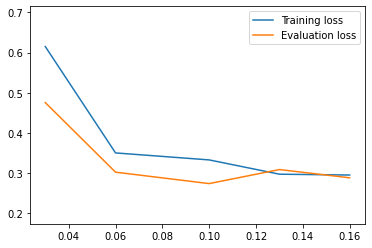

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

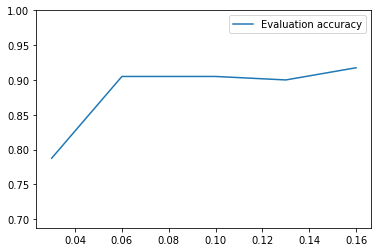

In [16]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])